Imports section. You basically neet to install the JupyterLab, MatPlotLib and Pandas libraries. To use some interactins in the notebook we are using ipywidgets as well.  
These are the pip commands to install the packes:<br>
**pip install jupyterlab<br>
pip install pandas<br>
pip install matplolib<br>
pip install ipywidgets**<br>

In order to get ipywidgets working with jupyter notebook please run the following command:<br>
**jupyter nbextension enable --py --sys-prefix widgetsnbextension**<br>

If you're using jupyter lab you also have to register the extension:<br>
**jupyter labextension install @jupyter-widgets/jupyterlab-manager**<br>
Please refer to: [https://github.com/jupyter-widgets/ipywidgets/blob/master/README.md](https://github.com/jupyter-widgets/ipywidgets/blob/master/README.md)
<br>

When exectuing the second command you may wonder that the terminal is somehow standing still. Don't worry, start the jupyter notebook in a second terminal using:<br>
**jupyter lab**<br>

Please refer to: [https://github.com/jupyter-widgets/ipywidgets/blob/master/README.md](https://github.com/jupyter-widgets/ipywidgets/blob/master/README.md)
<br>
For your convenience we added all of these indivdual installtion to one requirements text file that you can execute using the one and only following command (you will find requirements.txt in the root folder of this project):<br>
**pip install -r requirements.txt**<br><br>


In [15]:
import datetime
import math
import json
from json import load, dumps
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from pandas.io.json import json_normalize
from ipywidgets import widgets
from IPython.display import display, Javascript
import IPython
import re
import matplotlib.ticker as ticker



And now the class. The constructor takes a string containing the full filenname of a JSON database you can down load from the WHO website:

https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide

The database will be loaded and kept as a private member. To retrieve the data for an indvidual country you can use the public methods **GetCountryDataByGeoID** or **GetCountryDataByCountryName**. Refer to the JSON file for a list of available GeoIDs and CountryNames. Both methods will return a list of the following fields as a JSON:

**Date** The date of the data
**Country** The name of the country
**GeoID** The GeoID of the country such as FR for France or DE for Germany

**Cases** The number of cases on that day
**CumultativeCases** The accumulated number of cases since the 31.12.2019
**Quotient** The number of cases on the day devided by the number of cases of the previous day
**DoublingTime** The number of days in which the number of cases will be doubled

**Deaths** The number of deaths on the date
**CumultativeDeaths** The accumulated number of deaths since the 31.12.2019 
**PercentDeaths** The number of deaths in % of the cases

**CasesPerMillionPopulation** The number of cumulative cases devide by the popolation of the countryy in million 
    
**DeathsPerMillionPopulation** The number of cumulative deaths devide by the popolation of the countr in million


In [2]:
class CovidCases:
    """
    The constructor takes a string containing the full filenname of a JSON
    database you can down load from the WHO website:
    https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide

    The database will be loaded and kept as a private member. To retrieve the
    data for an indvidual country you can use the public methods
    GetCountryDataByGeoID or GetCountryDataByCountryName. Refer to the JSON
    file for a list of available GeoIDs and CountryNames. Both methods will
    return a list of the following fields as a JSON:
    
    Date
    The date of the data Country The name of the country
    
    GeoID
    The GeoID of the country such as FR for France or DE for Germany
    
    Population
    The popoluation of the country as of 2018
    
    Cases
    The number of cases on that day
    
    CumultativeCases
    The accumulated number of cases since the 31.12.2019
    
    Quotient
    The number of cases on the day devided by the number of cases of the
    previous day DoublingTime The number of days in which the number of cases
    will be doubled

    Deaths
    The number of deaths on the date
    
    CumultativeDeaths
    The accumulated number of deaths since the 31.12.2019
    
    PercentDeaths
    The number of deaths in % of the cases
    
    CasesPerMillionPopulation
    The number of cumulative cases devide by the popolation of the countryy in million 
    
    DeathsPerMillionPopulation
    The number of cumulative deaths devide by the popolation of the countr in million
    """

    def __get_common_attributes(self, record):
        """
        get a subset of attributes
        """
        return {
            "Country": record["countriesAndTerritories"],
            "GeoID": record["geoId"],
            "Population": record["popData2018"],
            "Date": record["dateRep"],
            "Cases": record["cases"],
            "Deaths": record["deaths"]
        }

    def __init__(self, filename):
        """
        constructor
        """
        # open the file and read the 'records'
        with open(filename) as f:
            self.__db = load(f)["records"]
        # map the subset
        # __db = [GetFields (r) for r in db]
        self.__db = list(map(lambda x: self.__get_common_attributes(x), self.__db))
        # dump the database
        # print(dumps(self.__db))
    
    def __get_all_records(self, f):
        """
        get all records
        """
        return lambda y: all([x(y) for x in f])

    def __add_extra_atributes(self, subset):
        """
        add some specific attributs
        """
        # the length of the list
        n = len(subset)
        # add a col to the first element having the number of cases
        subset[0].update({'CumultativeCases': int(subset[0]['Cases'])})
        subset[0].update({'CumultativeDeaths': int(subset[0]['Deaths'])})
        subset[0].update({'PercentDeaths': math.nan})
        subset[0].update({'CasesPerMillionPopulation': 0})
        subset[0].update({'DeathsPerMillionPopulation': 0})
        # loop through the list starting at index 1
        for x in range(1, n - 1):
            # the cumultative ncases of day n-1
            dayNm1Cum = int(subset[x-1]['CumultativeCases'])
            # the cases of day n
            dayN = int(subset[x]['Cases'])
            # the cumultative cases of day n
            dayNCum = dayNm1Cum + dayN
            subset[x].update({'CumultativeCases':  dayNCum})
            # the quuotient of day(n) / day(n-1)
            if dayNm1Cum != 0:
                subset[x].update({'Quotient':  dayNCum / dayNm1Cum})
            else:
                subset[x].update({'Quotient':  math.nan})
            quotient = float(subset[x]['Quotient'])
            # the doubling time in days
            if quotient != 1.0 and quotient != math.nan:
                subset[x].update({'DoublingTime': math.log(2) / math.log(quotient)})
            else:
                subset[x].update({'DoublingTime': math.nan})
            # the cumultative deaths of day n-1
            dayNm1CumDeaths = int(subset[x-1]['CumultativeDeaths'])
            # the deatha of day n
            dayN = int(subset[x]['Deaths'])
            # the cumultative deaths of day n
            dayNCumDeaths = dayNm1CumDeaths + dayN
            subset[x].update({'CumultativeDeaths':  dayNCumDeaths})
            # the number of deaths in percent of the cases
            if dayNCum != 0:
                subset[x].update({'PercentDeaths': dayNCumDeaths * 100 / dayNCum})
            else:
                subset[x].update({'PercentDeaths': math.nan})
            # the population in million
            population = int(subset[x]['Population']) / 1000000
            # cases per million
            casesPerMillion = dayNCum / population
            subset[x].update({'CasesPerMillionPopulation':  casesPerMillion})
            # deaths per million
            deathsPerMillion = dayNCumDeaths / population
            subset[x].update({'DeathsPerMillionPopulation':  deathsPerMillion})
            # print(subset[x])
        return subset

    def get_country_data_by_geoID(self, geoID, lastNdays=0):
        """
        return the list of cases by geoID
        """
        # specify the filter
        filters = []
        filters.append(lambda r: r["GeoID"] == geoID)
        # apply the filter
        subset = list(filter(self.__get_all_records(filters), self.__db))
        # reverse the list (1st date on top of the list)
        subset.reverse()
        subset = self.__add_extra_atributes(subset)
        if lastNdays > 0:
            start_index = len(subset) - lastNdays
            subset = subset[start_index:]
        return subset

    def get_country_data_by_country_name(self, countryName, lastNdays=0):
        """
        return the list of cases by country name
        """
        # specify the filter
        filters = []
        filters.append(lambda r: r["countriesAndTerritories"] == countryName)
        # apply the filter
        subset = list(filter(self.__get_all_records(filters), self.__db))
        # reverse the list (1st date on top of the list)
        subset.reverse()
        # add additonal fields
        subset = self.__add_extra_atributes(subset)
        if lastNdays > 0:
            start_index = len(subset) - lastNdays
            subset = subset[start_index:]
        return subset



We also use a Builder class in this project. It's very much configured for our needs of plotting a Pandas DataFrame. When using it you have to pass the name of the DataFrame column you want to plot as a constructor argument. Afterwards you're able to configure multiple plotting configurations like name, figure size, y-axis scale and so on. In the end you pass the DataFrame that should be plotted to the function plot_dataFrame and it outputs a beautiful matplotlib plot.

In [3]:
class PlotterBuilder:
    """
    A class that let's you easily build the wanted plotting configuration. If not further specified you get some
    default values like:
        - A figsize of 12, 8
        - No name
        - No grid
        - A linear y-axis-scale
        - A xaxis DateFormatter with format Y-m-d
    When plotting a DataFrame this class is always grouping by columns.
    """

    def __init__(self, yfield):
        """
        Creates an instance with mentioned default values.
        Parameter:
            yfield: The field of the DataFrame you want to plot.
        """
        self.__figsize = (12, 8)
        self.__title = ""
        self.__grid = False
        self.__yscale = 'linear'
        self.__xaxis_formatter = mdates.DateFormatter('%Y-%m-%d')
        self.__yfield = yfield

    def set_figsize(self, sizes):
        """
        Setter for the figure size.
        """
        self.__figsize = sizes
        return self

    def set_title(self, title):
        """
        Setter for the title.
        """
        self.__title = title
        return self

    def set_grid(self):
        """
        Sets the grid value to True.
        """
        self.__grid = True
        return self

    def set_log(self):
        """
        Formats the yscale to logarithmic.
        """
        self.__yscale = 'log'
        return self

    def set_xaxis_index(self):
        """
        Tells the x-axis that you don't want to plot a date.
        """
        self.__xaxis_formatter = None
        return self

    def build(self):
        """
        Builds the configured plotting object.
        Returns:
             fig: figure object
             ax: axis object with the wanted configurations.
        """
        fig, ax = plt.subplots(1, 1, figsize=self.__figsize)
        ax.set_title(self.__title)
        ax.set_yscale(self.__yscale)
        if self.__xaxis_formatter:
            ax.xaxis.set_major_formatter(self.__xaxis_formatter)

        return [fig, ax]

    def plot_dataFrame(self, df, **options):
        """
        Plots the DataFrame. If you want to plot an index on the x-axis you have to set it within the DataFrame object.
        If not the column date is used.
        """
        if self.__xaxis_formatter is None:
            # plot an index, not a date
            pldf = df.pivot_table(values=self.__yfield, index=df.index, columns='Country')
        else:
            # plot it with a date formatted x axis
            pldf = df.pivot_table(values=self.__yfield, index='Date', columns='Country')
        fig, ax = self.build()
        pldf.plot(ax=ax, **options)
        ax.grid(self.__grid)



As the repository uses Github actions we need to somehow inject special data into the notbook, this is done via this cell.

In [4]:
pathToJson = '../data/db.json'
githubAction = False


Using the class is pretty simple. Create an instance of the class using the full path to the filename and get the data for a specific country by calling<br> <i>data = covidCases.GetCountryDataByGeoID("DE")</i>. The geoID is equal to the country code of a toplevel domain. E.g. <i>DE</i> for Germany, <i>FR</i> for France, <i>JP</i> for Japan or <i>KR</i> for Korea.<br>
This code here accepts a list of comma separated countries to easily compare the data of multiple countries at once. Enter a string such as **DE, FR, IT, UK, ES** in the textbox below and press <i>Enter</i> **(don't forget that!)**:



In [16]:
# create an instance
covidCases = CovidCases(pathToJson)
# a list for our data
data = []
# split the string
geoIDs = re.split(r",\s*", "JP, KR, TW, SG")
# the number of last days to generate the data or 0 for all time
lastNdays = 0
# collect the data for all country codes
for geoID in geoIDs:
    data.append(covidCases.get_country_data_by_geoID(geoID, lastNdays))



Next we want to visualise the data in several diagrams. In a first step we need to concatinate the data fields of different countries that we want to visualise. Be aware of a proper date format in pandas. Next is to select the field that we want to display, indexed by the date having the countriy name as a column.


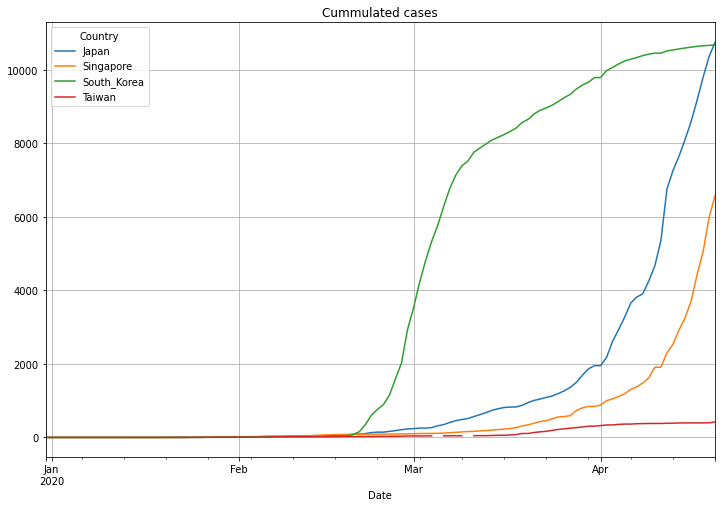

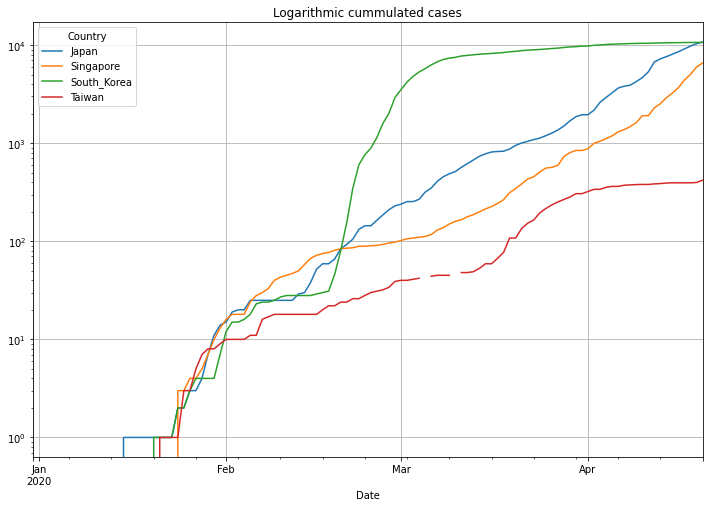

In [17]:
# convert results to a panda dataframes
# differntiate between a normal run and a github actions injected run
if not githubAction:
    dfdata = [pd.DataFrame(country_data) for country_data in data]
else:
    dfdata = [pd.DataFrame(country_data) for country_data in dataAction]
    
# concatinate both lists
df = pd.concat(dfdata)
# ensure the type of the 'Date' field
df['Date'] = pd.to_datetime(df['Date'], format = '%d/%m/%Y')

# plot with various axes scales, first with linear axis scale:
(PlotterBuilder('CumultativeCases') 
    .set_title('Cummulated cases') 
    .set_grid() 
    .plot_dataFrame(df))

# then logarithmic cummulated cases
(PlotterBuilder('CumultativeCases')
    .set_title('Logarithmic cummulated cases')
    .set_grid()
    .set_log()
    .plot_dataFrame(df))



The following shows a bargraph of cases per day:
    

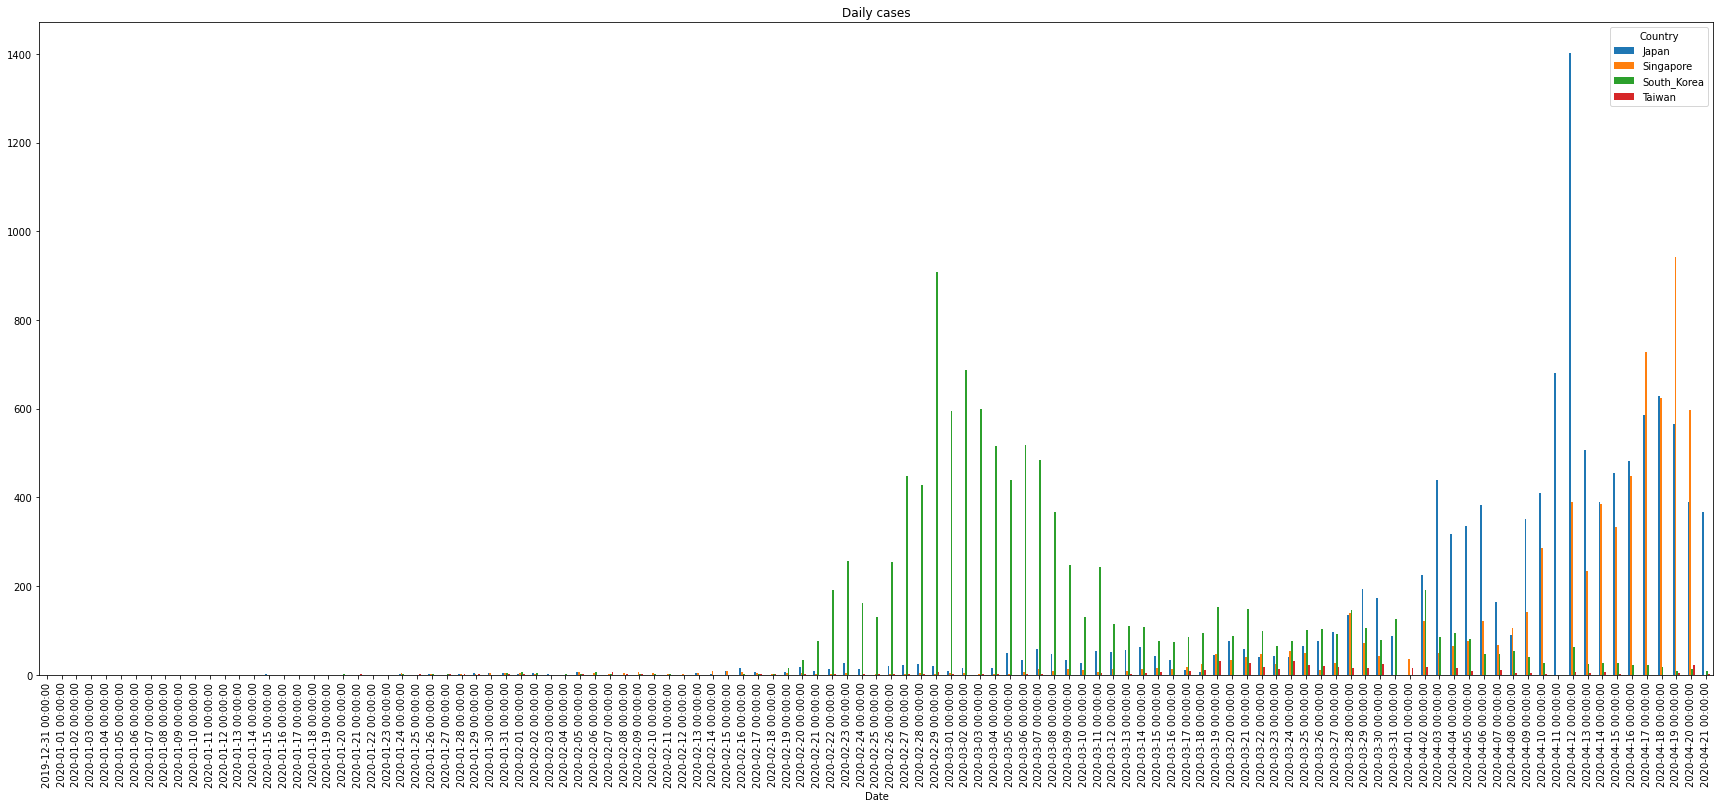

In [18]:
# ensure that cases are of a numeric type
df['Cases'] = pd.to_numeric(df['Cases'])

# plot the daily cases in a bar chart
(PlotterBuilder('Cases')
     .set_figsize((30, 12))
     .set_title('Daily cases')
     .plot_dataFrame(df, kind='bar'))



Now the graphs of the deaths:


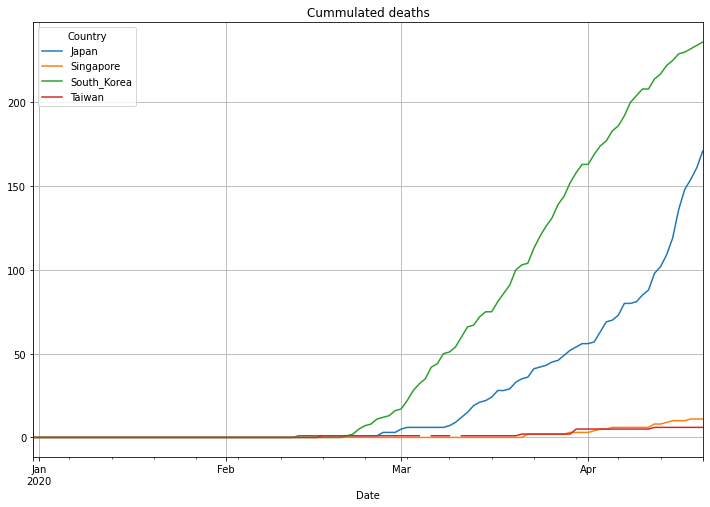

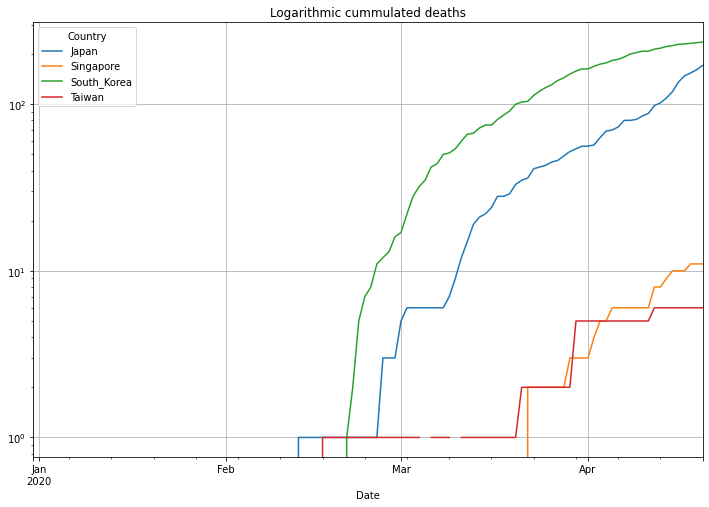

In [19]:
# plot cummulated deaths
(PlotterBuilder('CumultativeDeaths')
     .set_title('Cummulated deaths')
     .set_grid()
     .plot_dataFrame(df))

# plot cummulated deaths in logarithmic y-axis scale
(PlotterBuilder('CumultativeDeaths')
     .set_title('Logarithmic cummulated deaths')
     .set_grid()
     .set_log()
     .plot_dataFrame(df))


The number of deaths in percent of the cases. There is an interesting, not finished (17.04.2020), study in the village of Gangelt, Heinsberg county Germany, with 12000 citizen. A couple from the town was spending vacation in the Italian Lombardian area, the first hotspot in Italy. When they came back from vacation they attended 3 carnival parties in the village. Beside that the woman was working in a kinder garden. Both have been infected and the village became the first hotspot in Germany after a smaller outbreak at a Webasto fab in Bavaria. A team of the virology institute at the university of Bonn headed by professor Hendrik Streeckof tested 509 persons of 240 households on antibodies of Sars-CoV-2. As a result they found out that statistically 15% of the citizen had already antibodies, meaning an infection with Covid-19. Taking the amount of infected people and the number of deaths in the village into account it turns out, that the death rate was only 0,37%, a pretty low number. This leads to a simple problem: if the reported number of cases is low, then the death rate will be significantly higher. Interestingly Germany is doing Covid-19 tests massively and the death rate is significantly lower than in other countries with a higher death rate. This might be an indicator of less tests and therefore a high number of 'dark cases', cases that are not confirmed due to not enough tests.

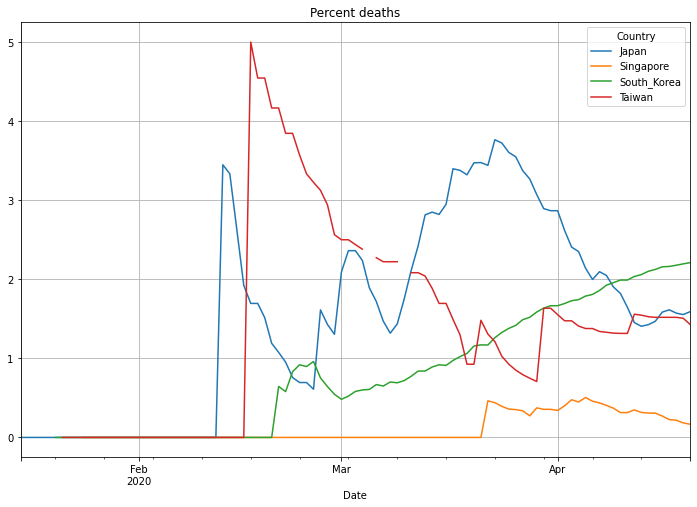

In [20]:
# plot the percent deaths with linear scale
(PlotterBuilder('PercentDeaths')
    .set_title('Percent deaths')
    .set_grid()
    .plot_dataFrame(df))



Now the number of cases per million population:
    

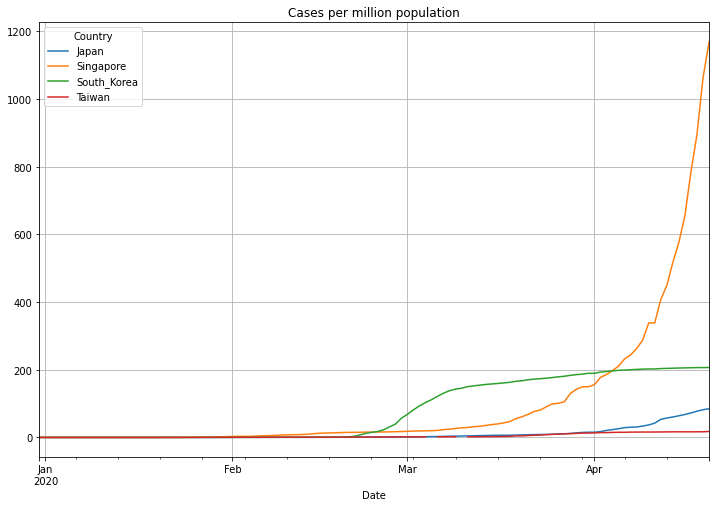

In [21]:
# plot the daily doubling time with linear scale
(PlotterBuilder('CasesPerMillionPopulation')
    .set_title('Cases per million population')
    .set_grid()
    .plot_dataFrame(df))



Now the number of deaths per million population. Be aware: some countries report not all deaths. The United Kingdom for instance reports only people that died in NHS facilities:
    

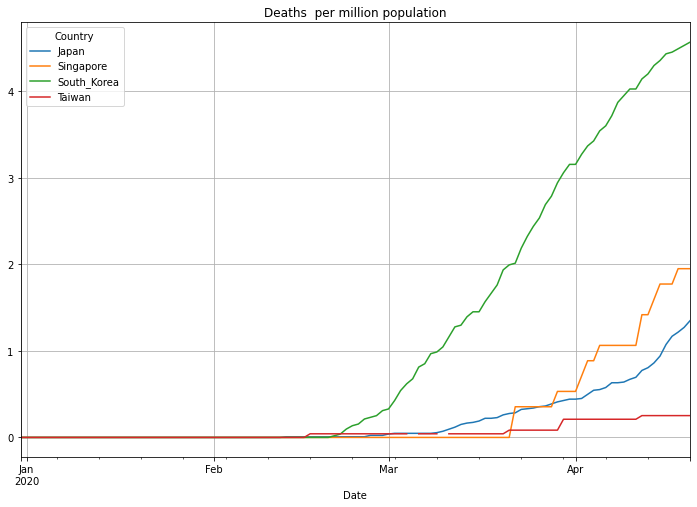

In [22]:
# plot the daily doubling time with linear scale
(PlotterBuilder('DeathsPerMillionPopulation')
    .set_title('Deaths  per million population')
    .set_grid()
    .plot_dataFrame(df))



Finally the doubling time which stands for the number of days it needs to double the number of cases. The higher this number, the better the situation is:
    

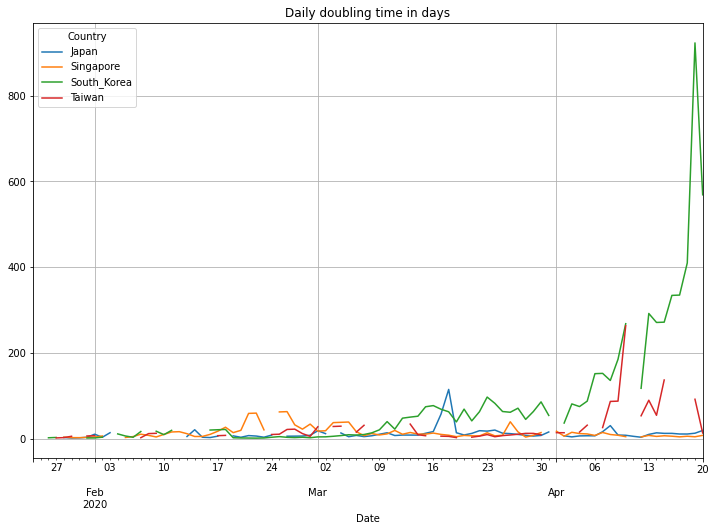

In [23]:
# plot the daily doubling time with linear scale
(PlotterBuilder('DoublingTime')
    .set_title('Daily doubling time in days')
    .set_grid()
    .plot_dataFrame(df))


What's missing so far is the calculation of the basic reproduction number R0. This number gives a chance to predict the number of cases over time. Refer to the SIR model and a online calculator:

https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology<br>
http://covidsim.eu<br>